In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from astropy.io import fits
from astropy.table import Table
from scipy.optimize import curve_fit

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)
from src.utils.constants import *
from src.utils.functions import *
from src.utils.CosmoFunc import *

# Combined sample

Median logdist without PV model subtraction:  -0.00605058497555955
Mean logdist without PV model subtraction:  -0.009107631565612645

Median logdist after PV model subtraction:  -0.00460907906754285
Mean logdist after PV model subtraction:  -0.007881075246212331


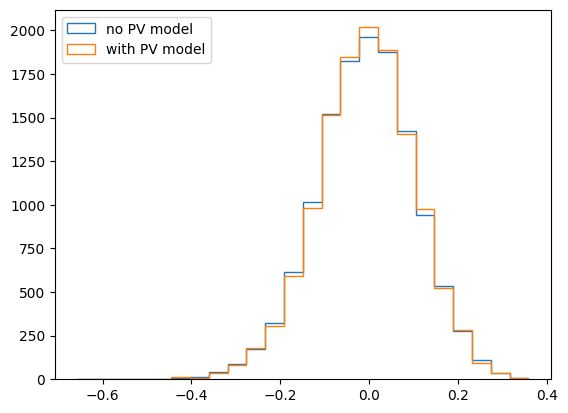

In [12]:
df_combined_before = pd.DataFrame()
for survey in ["6dFGS", "SDSS", "LAMOST"]:
    df_temp = pd.read_csv(f"../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey}.csv")
    df_combined_before = pd.concat([df_combined_before, df_temp], axis=0).reset_index(drop=True)
logdist_before = df_combined_before['logdist_all_combined'].to_numpy()
print("Median logdist without PV model subtraction: ", np.median(logdist_before))
print("Mean logdist without PV model subtraction: ", np.mean(logdist_before))
print()

df_combined_after = pd.DataFrame()
for survey in ["6dFGS", "SDSS", "LAMOST"]:
    df_temp = pd.read_csv(f"./{survey}.csv")
    df_combined_after = pd.concat([df_combined_after, df_temp], axis=0).reset_index(drop=True)
logdist_after = df_combined_after['logdist_all_combined'].to_numpy()
print("Median logdist after PV model subtraction: ", np.median(logdist_after))
print("Mean logdist after PV model subtraction: ", np.mean(logdist_after))

x_min = min(logdist_before.min(), logdist_after.min())
x_max = max(logdist_before.max(), logdist_after.max())
x_bins = np.linspace(x_min, x_max, 25)

plt.hist(logdist_before, bins=x_bins, label='no PV model', histtype="step")
plt.hist(logdist_after, bins=x_bins, label='with PV model', histtype="step")
plt.legend()

# Each survey

=========================6dFGS=========================
Median logdist without PV subtraction:  0.0145435505966508
Mean logdist without PV subtraction:  0.007859727506264385
Std logdist without PV subtraction:  0.11467677349531213

Median logdist after PV subtraction:  0.010856341203634
Mean logdist after PV subtraction:  0.004409663697926872
Std logdist after PV subtraction:  0.11478692317213492


=========================SDSS=========================
Median logdist without PV subtraction:  -0.019657722986869
Mean logdist without PV subtraction:  -0.018467689816344838
Std logdist without PV subtraction:  0.09563354292806449

Median logdist after PV subtraction:  -0.0149878740529258
Mean logdist after PV subtraction:  -0.013612747660356705
Std logdist after PV subtraction:  0.0954909928224927


=========================LAMOST=========================
Median logdist without PV subtraction:  -0.03618560377387385
Mean logdist without PV subtraction:  -0.038982950484549944
Std logdist with

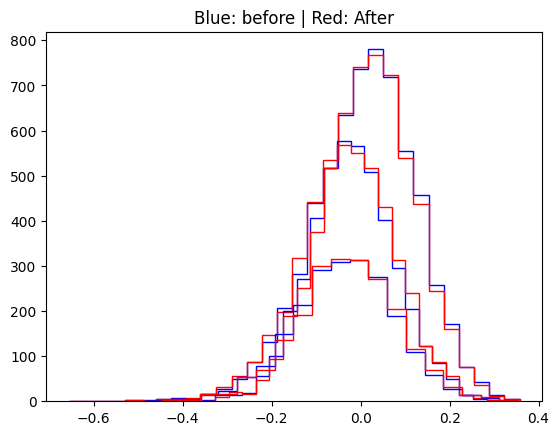

In [2]:
for survey in ["6dFGS", "SDSS", "LAMOST"]:
    print("=" * 25 + survey + "=" * 25)
    df_before = pd.read_csv(f"../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")
    logdist_before = df_before['logdist_all_combined'].to_numpy()
    print("Median logdist without PV subtraction: ", np.median(logdist_before))
    print("Mean logdist without PV subtraction: ", np.mean(logdist_before))
    print("Std logdist without PV subtraction: ", np.std(logdist_before))
    print()

    df_after = pd.read_csv(f"./{survey}.csv")
    logdist_after = df_after['logdist_all_combined'].to_numpy()
    print("Median logdist after PV subtraction: ", np.median(logdist_after))
    print("Mean logdist after PV subtraction: ", np.mean(logdist_after))
    print("Std logdist after PV subtraction: ", np.std(logdist_after))
    print()
    print()

    x_min = min(logdist_before.min(), logdist_after.min())
    x_max = max(logdist_before.max(), logdist_after.max())
    x_bins = np.linspace(x_min, x_max, 25)

    plt.hist(logdist_before, bins=x_bins, histtype="step", color='b')
    plt.hist(logdist_after, bins=x_bins, histtype="step", color='r')
    plt.title("Blue: before | Red: After")

In [5]:
logdist_before.min()

-0.4605053073401767

In [3]:
class MLTrainingTaskConfig(BaseModel):
    hyperparameters: Optional[Dict[str, Any]] = Field(default_factory=dict)

SyntaxError: incomplete input (1500736897.py, line 1)

# Internal Consistency Plot